In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("full_df.csv")
data.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


##### Normal (N),
##### Diabetes (D),
##### Glaucoma (G),
##### Cataract (C),
##### Age related Macular Degeneration (A),
##### Hypertension (H),
##### Pathological Myopia (M),
##### Other diseases/abnormalities (O)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [5]:
data[data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

In [6]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

In [7]:
def process_dataset(data):
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
  
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
  
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values 
    
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);
    
    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [8]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats:")
print("Normal :" , len(normal))
print("Cataract :" , len(cataract))
print("Diabetes :" , len(diab))
print("Glaucoma :" , len(glaucoma))
print("Hypertension :" , len(hyper))
print("Myopia :" , len(myopia))
print("Age Issues :" , len(age))
print("Other :" , len(other))

Dataset stats:
Normal : 700
Cataract : 594
Diabetes : 1818
Glaucoma : 610
Hypertension : 374
Myopia : 479
Age Issues : 551
Other : 324


In [9]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "preprocessed_images"
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir,img);
        
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);
    
    return dataset;

In [10]:
import cv2

img = cv2.imread('preprocessed_images/113_right.jpg')

if img is None:
    print("Görüntü yüklenemedi.")
else:
    resized_img = cv2.resize(img, (224, 224))  

    if resized_img is None:
        print("Ölçekleme işlemi başarısız.")
    else:
        cv2.imshow('Resized Image', resized_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [11]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [12]:
dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

len(dataset)

100%|███████████████████████████████████████████████████████████████████████████████| 324/324 [00:02<00:00, 151.81it/s]


5396

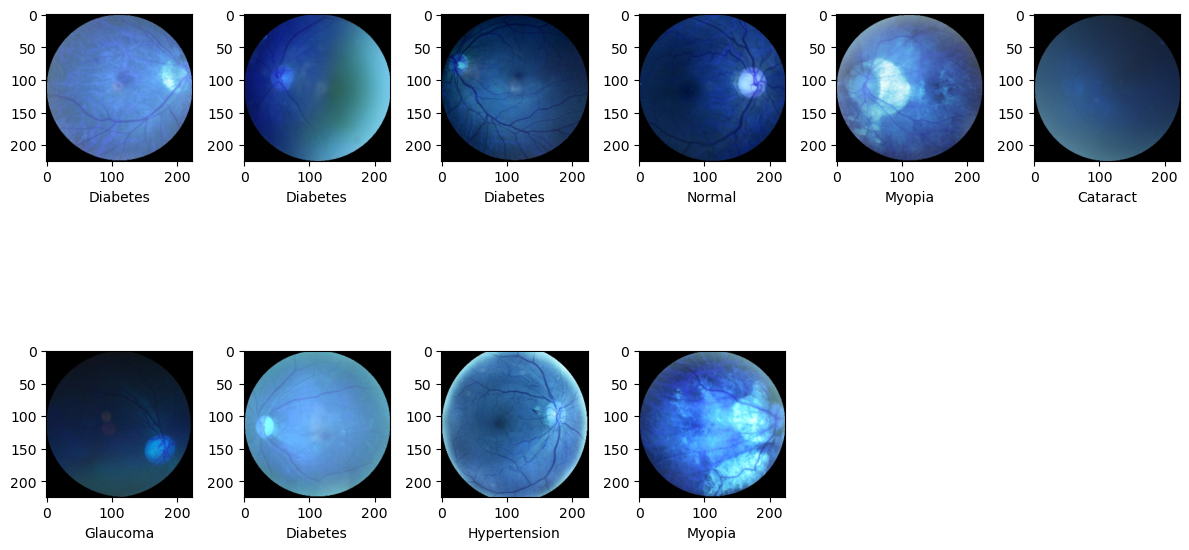

In [13]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
           
    plt.subplot(2,6,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [14]:
train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)

y_train_cat = to_categorical(y_train,num_classes=8)

y_test_cat = to_categorical(y_test,num_classes = 8)

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf
vgg = VGG16(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(8,activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [16]:
for i in model.layers:
    print(i.name)

vgg16
flatten
dense
batch_normalization
dense_1
batch_normalization_1
dense_2


In [17]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
history = model.fit(x_train,y_train_cat,batch_size=32,epochs=8)
print(history)

Epoch 1/8
135/135 [==============================] - 367s 3s/step - loss: 1.3613 - accuracy: 0.5568
Epoch 2/8
135/135 [==============================] - 367s 3s/step - loss: 0.6555 - accuracy: 0.7831
Epoch 3/8
135/135 [==============================] - 386s 3s/step - loss: 0.4288 - accuracy: 0.8779
Epoch 4/8
135/135 [==============================] - 410s 3s/step - loss: 0.2827 - accuracy: 0.9171
Epoch 5/8
135/135 [==============================] - 381s 3s/step - loss: 0.2254 - accuracy: 0.9398
Epoch 6/8
135/135 [==============================] - 392s 3s/step - loss: 0.2106 - accuracy: 0.9416
Epoch 7/8
135/135 [==============================] - 426s 3s/step - loss: 0.1835 - accuracy: 0.9460
Epoch 8/8
135/135 [==============================] - 381s 3s/step - loss: 0.1567 - accuracy: 0.9502


In [18]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [20]:
loss,accuracy = model.evaluate(x_test,y_test_cat)
print("Accuracy:",accuracy)

34/34 [==============================] - 91s 3s/step - loss: 0.9441 - accuracy: 0.7843
Accuracy: 0.7842592597007751


In [21]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred = []
for i in model.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

34/34 [==============================] - 88s 3s/step


In [22]:
print(accuracy_score(y_test,y_pred))

0.7842592592592592


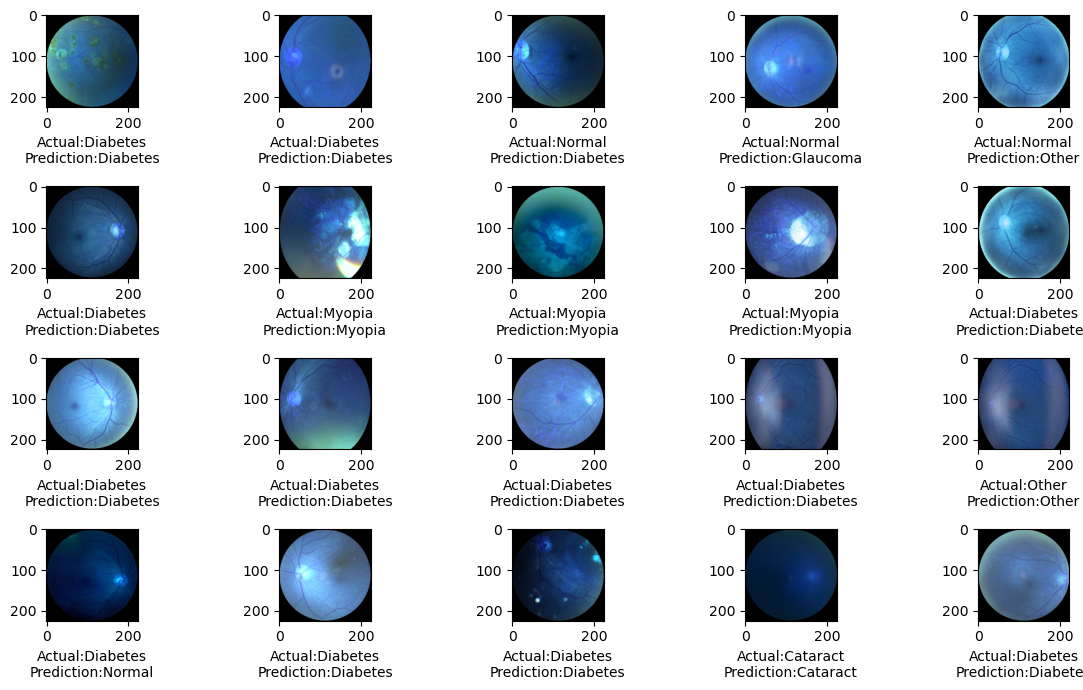

In [23]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

In [24]:
model.save("keras_model.keras")